In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import scipy as sci

% matplotlib inline

In [13]:
L = 1
alpha = 1
beta = 0

def f(x):
    #return 0.0  # L = 1 alpha = 1, beta = 0
    #return -2.0 # L = 1 alpha = -1 beta = 1
    #return -2.0 # L = 3 alpha = 0, beta = 0
    return np.exp(x)*(1 - 2*x - x**2) # L = 1 alpha = 1, beta = 0
    #return 1.0

def u(x):
    #return 1 - x # L = 1, alpha = 1, beta = 0
    #return x**2 + x - 1 # L = 1, alpha = -1, beta = 1
    #return x**2 - 3*x # L = 3, alpha = beta = 0
    return np.exp(x)*((1-x)**2) # L = 1 alpha = 1, beta = 0

In [14]:
# use a uniform mesh spacing 
N = 500
x = np.linspace(0,L,N+1)
h = x[1] - x[0]
degree = 6

g_nodes,g_weights = np.polynomial.legendre.leggauss(degree)

Solves a 1D problem BVP:
\begin{align}
-u''(x) = f(x)\\
u(0) = \alpha \\
u(L) = \beta
\end{align}

with the choice $f(x) = e^x -2xe^x -x^2e^x$, $L = 1$, $\alpha = 1$, $\beta = 0$, the solution is given by
\begin{equation}
u(x) = (1-x)^2e^x
\end{equation}
The code currently solves with linear discontinuous elements and uniform spacing, and uniform jump parameters.  It also enforces boundary conditions weakly.

Integrate with a test function over the interval $[x_n, x_{n+1}]$, and apply integration by parts:
\begin{align}
\int_{x_n}^{x_{n+1}}u'(x)v'(x) dx - u'(x_{n+1})v(x_{n+1}^-) + u'(x_n)v(x_n^+) = \int_{x_n}^{x_{n+1}}f(x)v(x)dx
\end{align}

Define jumps and averages at interior nodes (1 through N-1) as:
\begin{align}
[v(x_n)] = (v(x_n^-) - v(x_n^+))\\
\{v(x_n)\} = \frac{1}{2}(v(x_n^+) + v(x_n^-))
\end{align}
At the endpoints the definitions are:
\begin{align}
[v(x_0)] = - v(x_0)\\
[v(x_N)] = v(x_N)\\
\{v(x_0)\} = v(x_0)\\
\{v(x_N)\} = v(x_N)
\end{align}

Summing over the elements and using the fact that the solution $u \in C^1(0,L)$ (so $u'$ has no jumps), and using the identity:
\begin{equation}
[uv] = \{u\}[v] + [u]\{v\}
\end{equation}
We get:
\begin{equation}
\sum_{n=0}^{N-1}\int_{x_n}^{x_{n+1}}u'v'dx - \sum_{n=0}^{N}\{u'(x_n)\}[v(x_n)] = \sum_{n=0}^{N-1}\int_{x_n}^{x_{n+1}}fv dx
\end{equation}

Under the partition $0 = x_0,\dots,x_N = 1$, with uniform spacing we want to solve bilinear form:
\begin{equation}
a_{ \epsilon}(u,v) = L_{\epsilon}(v)
\end{equation}
defined as follows:
\begin{equation}
a_{\epsilon} = \sum_{n=0}^{N-1} \int_{x_n}^{x_{n+1}} u'(x)v'(x) dx - \sum_{n=0}^{N} \{u'(x_n)\} [v(x_n)]
+\epsilon \sum_{n=0}^N\{v'(x_n)\} [u(x_n)] + J_0(u,v) + J_1(u,v)
\end{equation}
where 
\begin{align}
J_0(u,v) = \sum_{n=0}^N \frac{\sigma_0}{h}[v(x_n)][u(x_n)] \\
J_1(u,v) = \sum_{n=1}^{N-1}\frac{\sigma_1}{h}[v'(x_n)][u'(x_n)]
\end{align}
and $\epsilon$ takes values of 0, 1, and 2.

\begin{align}
L_{\epsilon}(v) = \sum_{n=0}^{N-1}\int_{x_n}^{x_{n+1}} f(x)v(x)dx - \epsilon v'(x_0)\alpha + \epsilon v'(x_N)\beta + \frac{\sigma_0}{h}v(x_0)\alpha +\frac{\sigma_0}{h}v(x_N)\beta
\end{align}
We've simply added 3 terms to the weak form, and used the continuity and boundary conditions of the true solution
Assembly of $A$ should be split into 3 parts: Integrals over subintervals, constraints at interior nodes, and constraints at exterior nodes.  Both boundary conditions will be enforced weakly!!!

First, we assemble the local matrix $A_n$ which is the discrete form of the integral over every element:
\begin{equation}
(A_n)_{ij} = \int_{x_n}^{x_{n+1}} \phi_j ' (x) \phi_i '(x) dx
\end{equation}
$A_n$ has the following form for elements 1 through $n$:
\begin{equation}
A_n = \frac{1}{h}\begin{pmatrix}
1 & -1 \\
-1 & 1
\end{pmatrix}
\end{equation}
Every element requires this, so these local matrices will be part of the diagonal of global matrix

Next, we compute contributions to inner nodes.  Expanding $- \sum_{n=0}^{N} \{u'(x_n)\} [v(x_n)]
+\epsilon \sum_{n=0}^N\{v'(x_n)\} [u(x_n)] + J_0(u,v) + J_1(u,v)$ (restricting our selves to interior nodes), we get four types of constraints.  The first is:

\begin{align}
u^+v^+: \frac{1}{2}\phi_j ' (x_n^+)\phi_i(x_n^+) - \frac{\epsilon}{2}\phi_j(x_n^+)\phi_i ' (x_n^+) + \frac{\sigma_0}{h}\phi_j(x_n^+)\phi_i(x_n^+) + \frac{\sigma_1}{h}\phi_j ' (x_n^+) \phi_i ' (x_n^+)
\end{align}
with local matrix
\begin{equation}
B_n = \frac{1}{h} \begin{pmatrix}
\frac{\epsilon}{2} - \frac{1}{2} + \sigma_0 + \frac{\sigma_1}{h^2} & -\frac{\epsilon}{2} - \frac{\sigma_1}{h^2}\\
\frac{1}{2} - \frac{\sigma_1}{h^2} & \frac{\sigma_1}{h^2}
\end{pmatrix}
\end{equation}
These are additional constraints within element $n+1$ (to the right of the interior node).  Subsequently, they will be added to the diagonal, excluding the 1st element (empty upper left-hand block)

2nd type:
\begin{align}
u^-v^-: -\frac{1}{2}\phi_j ' (x_n^-)\phi_i(x_n^-) + \frac{\epsilon}{2}\phi_j(x_n^-)\phi_i ' (x_n^-) + \frac{\sigma_0}{h}\phi_j(x_n^-)\phi_i(x_n^-) + \frac{\sigma_1}{h}\phi_j ' (x_n^-) \phi_i ' (x_n^-)
\end{align}
with matrix:
\begin{equation}
C_n = \frac{1}{h} \begin{pmatrix}
\frac{\sigma_1}{h^2} & \frac{1}{2} - \frac{\sigma_1}{h^2}\\
-\frac{\epsilon}{2} - \frac{\sigma_1}{h^2} & -\frac{1}{2} + \frac{\epsilon}{2} + \sigma_0 + \frac{\sigma_1}{h^2}
\end{pmatrix}
\end{equation}
These are additional constraints within element $n$ (to the left of the interior node).  They will be added to the diagonal, excluding the last element (empty lower right-hand block)

Now we need inter-node coupling.  The first type:
\begin{align}
u^+v^-: -\frac{1}{2}\phi_j ' (x_n^+)\phi_i(x_n^-) - \frac{\epsilon}{2}\phi_j(x_n^+)\phi_i ' (x_n^-) - \frac{\sigma_0}{h}\phi_j(x_n^+)\phi_i(x_n^-) - \frac{\sigma_1}{h}\phi_j ' (x_n^+) \phi_i ' (x_n^-)
\end{align}
with matrix:
\begin{equation}
D_n = \frac{1}{h} \begin{pmatrix}
\frac{\epsilon}{2} - \frac{\sigma_1}{h^2} & \frac{\sigma_1}{h^2}\\
\frac{1}{2} - \frac{\epsilon}{2} - \sigma_0 + \frac{\sigma_1}{h^2} & -\frac{1}{2} - \frac{\sigma_1}{h^2}
\end{pmatrix}
\end{equation}
This couples test functions in element $n$ to trial functions in element $n+1$, and so is on the superdiagonal

The second type of coupling is:
\begin{align}
u^-v^+: \frac{1}{2}\phi_j ' (x_n^-)\phi_i(x_n^+) + \frac{\epsilon}{2}\phi_j(x_n^-)\phi_i ' (x_n^+) - \frac{\sigma_0}{h}\phi_j(x_n^-)\phi_i(x_n^+) - \frac{\sigma_1}{h}\phi_j ' (x_n^-) \phi_i ' (x_n^+)
\end{align}
With matrix:
\begin{equation}
E_n = \frac{1}{h}\begin{pmatrix}
-\frac{1}{2} - \frac{\sigma_1}{h^2} & \frac{1}{2} - \frac{\epsilon}{2} - \sigma_0 + \frac{\sigma_1}{h^2}\\
\frac{\sigma_1}{h^2} & \frac{\epsilon}{2} - \frac{\sigma_1}{h^2}
\end{pmatrix}
\end{equation}
This couples test functions in element $n+1$ to trial functions in element $n$, and so is on the subdiagonal.

Finally, we need contributions from the two exterior nodes.  First, $x_0$:
\begin{equation}
\phi_j ' (x_0)\phi_i (x_0) - \epsilon \phi_j (x_0)\phi_i ' (x_0) + \frac{\sigma_0}{h}\phi_j(x_0)\phi_i(x_0)
\end{equation}
The local matrix is:
\begin{equation}
F_0 = \frac{1}{h} \begin{pmatrix}
\epsilon + \sigma_0 - 1 & 1\\
-\epsilon & 0 \end{pmatrix}
\end{equation}
This only affects element 1 so will appear in upper left block

Then $x_1$:
\begin{equation}
-\phi_j ' (x_N) \phi_i (x_N) + \epsilon \phi_j(x_N) \phi_i ' (x_N) + \frac{\sigma}{h}\phi_j(x_N)\phi_i(x_N)
\end{equation}
The local matrix is:
\begin{equation}
F_N = \frac{1}{h} \begin{pmatrix}
0 & -\epsilon\\
1 & \epsilon + \sigma_0 - 1 \end{pmatrix}
\end{equation}
This will be added to lower right hand block

The overall matrix will have the form:
\begin{equation}
\begin{pmatrix}
A_0 + C_1 + F_0 & D1 & 0 & \dots & \dots & 0\\
E_1 & A_1 + B_1 + C_2 & D2 & 0 & \dots & 0 \\
0 & E_2 & A_2 + B_2 + C_3 & D_3 & 0 & 0\\
\vdots & \vdots & \ddots & \ddots & \vdots & \vdots\\
\vdots & \vdots & \ddots & \ddots & D_{N-2} & \vdots \\
0 & 0 & 0 & E_{N-2} & A_{N-2} + B_{N-2} + C_{N-1} & D_{N-1} \\
0 & 0 & 0 & 0 & E_{N-1} &A_{N-1} + B_{N-1} + F_N
\end{pmatrix}
\end{equation}

The right hand side is a little more straightforward.  On each element $n$, the integral $\int_{x_n}^{x_{n+1}} f(x)\phi_i^n dx$ must be computed for $i = 1,2$ (using gauss quadrature).  In addition, the first component must have the additional terms $\frac{\alpha}{h}(\sigma_0+\epsilon)$, the second component must have $-\frac{\alpha \epsilon}{h}$, the second to last component $-\frac{\beta\epsilon}{h}$ and the final component $\frac{\beta}{h}(\sigma_0 + \epsilon)$

In [15]:
# We are going to impose boundary conditions weakly
# We'll do piecewise linears first
# h, sigma_0 and sigma_1 are constant initially

def local_A(h):
    A = np.array([[1.0,-1.0],[-1.0,1.0]])
    A = A/h
    return A 

def local_B(h,eps,sig_0,sig_1):
    B11 = eps/2 - 0.5 + sig_0 + sig_1/(h**2)
    
    B12 = -sig_1/(h**2) - eps/2
    
    B21 = 0.5 - sig_1/(h**2)
    
    B22 = sig_1/(h**2)
    B = np.array([[B11,B12],[B21,B22]])
    B = B/h
    return B

def local_C(h,eps,sig_0,sig_1):
    C11 = sig_1/(h**2)
    C12 = 0.5 - sig_1/(h**2)
    C21 = -eps/2 - sig_1/(h**2)
    C22 = -0.5 + eps/2 + sig_0 + sig_1/(h**2)
    C = np.array([[C11, C12],[C21,C22]])    
    C = C/h
    return C

def local_D(h,eps,sig_0,sig_1):
    D11 = eps/2 - sig_1/(h**2)
    D12 = sig_1/(h**2)
    D21 = 0.5 - eps/2 - sig_0 + sig_1/(h**2)
    D22 = -0.5 - sig_1/(h**2)
    D = np.array([[D11,D12],[D21,D22]])
    D = D/h
    return D

def local_E(h,eps,sig_0,sig_1):
    E11 = -0.5 - sig_1/(h**2)
    E12 = 0.5 - eps/2 - sig_0 + sig_1/(h**2)
    E21 = sig_1/(h**2)
    E22 = eps/2 - sig_1/(h**2)
    E = np.array([[E11,E12],[E21,E22]])
    E = E/h
    return E

def local_F_0(h,eps,sig_0):
    F11 = eps + sig_0 - 1
    F12 = 1
    F21 = -eps
    F22 = 0
    F = np.array([[F11,F12],[F21,F22]])
    F = F/h
    return F

def local_F_N(h,eps,sig_0):
    F11 = 0
    F12 = -eps
    F21 = 1
    F22 = eps + sig_0 - 1
    F = np.array([[F11,F12],[F21,F22]])
    F = F/h
    return F
    
def assemble_matrix(h,eps,sig_0,sig_1,N):
    A_global = np.zeros((2*N,2*N))
    A_global[0:2,0:2] += local_A(h) + local_C(h,eps,sig_0,sig_1) + local_F_0(h,eps,sig_0)
    A_global[0:2,2:4] += local_D(h,eps,sig_0,sig_1)
    for e in range(1,N-1):
        i = e*2
        A_global[i:(i+2),i:(i+2)] += local_A(h) + local_B(h,eps,sig_0,sig_1) + local_C(h,eps,sig_0,sig_1)
        A_global[i:(i+2),(i-2):i] += local_E(h,eps,sig_0,sig_1)
        A_global[i:(i+2),(i+2):(i+4)] += local_D(h,eps,sig_0,sig_1)
    
    i = 2*N-2
    A_global[i:(i+2),i:(i+2)] += local_A(h) + local_B(h,eps,sig_0,sig_1) + local_F_N(h,eps,sig_0)
    A_global[i:(i+2),(i-2):i] += local_E(h,eps,sig_0,sig_1)
    
    return A_global
    

In [16]:
def local_basis_0(x,x0,x1):
    z = (x1 - x)/(x1 - x0)
    return z

def local_basis_1(x,x0,x1):
    z = (x - x0)/(x1 - x0)
    return z

def int_f(f,basis,x0,x1,z,g_weights):
    u = f(z)*basis(z,x0,x1)
    integral = g_weights.dot(u)
    integral *= (x1 - x0)/2
    return integral
    

def integral_vector(f,x0,x1,g_nodes,g_weights):
    dx = x1 - x0
    z = (dx*g_nodes)/2 + (x1 + x0)/2
    local_vec = np.zeros(2,)
    local_vec[0] = int_f(f,local_basis_0,x0,x1,z,g_weights)
    local_vec[1] = int_f(f,local_basis_1,x0,x1,z,g_weights)
    return local_vec

def assemble_vector(h,eps,sig_0,N,g_nodes,g_weights,x,alpha,beta):
    b = np.zeros(2*N,)
    b[0:2] = integral_vector(f,x[0],x[1],g_nodes,g_weights)
    b[0] += alpha*(sig_0 + eps)/h
    b[1] -= alpha*eps/h
    
    for e in range(1,N):
        i = e*2
        b[i:(i+2)] = integral_vector(f,x[e],x[e+1],g_nodes,g_weights)
        
    b[-2] -= beta*eps/h
    b[-1] += beta*(sig_0 + eps)/h
    return b

In [17]:
eps = -1
sig_0 = 2.0
sig_1 = 0.0
A = assemble_matrix(h,eps,sig_0,sig_1,N)
b = assemble_vector(h,eps,sig_0,N,g_nodes,g_weights,x,alpha,beta)

In [18]:
c = la.solve(A,b)

In [19]:
xplot = np.zeros(2*N,)
xplot[0] = x[0]
for i in range(1,N):
    xplot[2*i - 1] = x[i]
    xplot[2*i] = x[i]
    
xplot[-1] = x[-1]

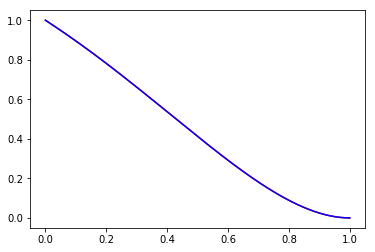

In [20]:
plt.plot(x,u(x),'r')
plt.plot(xplot,c,'b')

DG solution and true solution are indistinguishable